In [2]:
!pip install findspark


Defaulting to user installation because normal site-packages is not writeable


In [3]:
import findspark
findspark.init()


In [4]:
from pyspark.sql import SparkSession

spark = SparkSession.builder.appName("MySparkApp").getOrCreate()


24/02/19 14:51:43 WARN Utils: Your hostname, tejasshinde-Nitro-AN515-55 resolves to a loopback address: 127.0.1.1; using 192.168.1.157 instead (on interface wlp0s20f3)
24/02/19 14:51:43 WARN Utils: Set SPARK_LOCAL_IP if you need to bind to another address
Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).
24/02/19 14:51:45 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable


# Load Clean Data

In [5]:
data_path = "nonull.csv"
df= spark.read.csv(data_path, header=True, inferSchema=True)



In [6]:
df.show()

+-------------------+-------------------+-------------------+-------------------+-------+------+-----------+-----------+---------------+-------------------+
|         event_time|           order_id|         product_id|        category_id|  brand| price|      cat_1|      cat_2|          cat_3|            user_id|
+-------------------+-------------------+-------------------+-------------------+-------+------+-----------+-----------+---------------+-------------------+
|2020-04-29 20:11:49|2298069964415828136|1515966223509122874|2268105407933187062|     hp|152.52|  computers|peripherals|        printer|1515915625509647001|
|2020-04-29 23:42:11|2298175846491357353|1515966223509122666|2268105430162997728|samsung|  8.08|electronics|      audio|      headphone|1515915625511889093|
|2020-04-30 18:01:51|2298729326712980173|1515966223509089265|2360741866917331945|   beko|231.46| appliances|environment|air_conditioner|1515915625510823948|
|2020-04-30 19:27:36|2298772487720140990|15159662235093354

In [6]:
# from pyspark.sql.functions import col, to_date

# # Create new column Date from event_time column
# df_date = df.withColumn("Date", to_date(col("event_time")))

# df_date.show()




In [7]:
# output_path = "WithDate"
# df_date.coalesce(1).write.csv(output_path, header=True)


# Calculate RFM Values

In [7]:
from pyspark.sql.functions import col, max as max_, countDistinct, sum as sum_, datediff, lit

# Initialize SparkSession
spark = SparkSession.builder \
    .appName("RFM_Scores_Calculation") \
    .getOrCreate()


# Step 1: Calculate recency, frequency, and monetary values

# Calculate recency (number of days since the last order)
max_order_date = df.groupBy("user_id").agg(max_("event_time").alias("last_order_time"))
current_time = df.select(max_("event_time")).head()[0]
df_recency = max_order_date.withColumn("recency", datediff(lit(current_time), col("last_order_time")))

# Calculate frequency (number of orders per user)
df_frequency = df.groupBy("user_id").agg(countDistinct("order_id").alias("frequency"))

# Calculate monetary value (total spending per user)
df_monetary = df.groupBy("user_id").agg(sum_("price").alias("monetary"))

# Step 2: Define the time frame for recency calculation (e.g., 90 days)

# Step 3: Aggregate the data to calculate RFM scores
rfm_data = df_recency.join(df_frequency, "user_id").join(df_monetary, "user_id")

# Show the RFM data
rfm_data.show()




24/02/19 14:52:31 WARN SparkSession: Using an existing Spark session; only runtime SQL configurations will take effect.


+-------------------+-------------------+-------+---------+------------------+
|            user_id|    last_order_time|recency|frequency|          monetary|
+-------------------+-------------------+-------+---------+------------------+
|1515915625440051468|2020-10-10 16:27:29|     42|       19|           1619.51|
|1515915625440121544|2020-10-04 12:18:21|     48|        7|            878.32|
|1515915625440937295|2020-11-19 15:36:46|      2|       18|1493.3400000000001|
|1515915625440937382|2020-10-25 17:36:25|     27|       10| 757.6599999999999|
|1515915625440937580|2020-10-10 10:52:42|     42|        8|            275.05|
|1515915625440940742|2020-09-16 13:59:35|     66|        2|59.910000000000004|
|1515915625440940932|2020-09-01 13:45:29|     81|        6|1854.2500000000002|
|1515915625440941441|2020-01-16 12:06:23|    310|        1|             80.76|
|1515915625440943934|2020-10-11 17:17:47|     41|       24| 5877.459999999999|
|1515915625440945265|2020-11-18 19:45:39|      3|   

In [8]:
rfm_data.count()

218524

# Download RFM Data

In [22]:
output_path = "RFMData"
rfm_data.coalesce(1).write.csv(output_path, header=True)


In [12]:
from pyspark.ml.clustering import KMeans
from pyspark.ml.feature import VectorAssembler
from pyspark.sql import SparkSession

# Initialize SparkSession
spark = SparkSession.builder \
    .appName("RFM_Clustering") \
    .getOrCreate()

# Assemble the RFM values into a feature vector
assembler = VectorAssembler(inputCols=["recency", "frequency", "monetary"], outputCol="features")
rfm_features = assembler.transform(rfm_data).select("user_id", "features")

# Initialize KMeans with the number of clusters
kmeans = KMeans(k=5, seed=42)

# Fit the KMeans model to the data
model = kmeans.fit(rfm_features)

# Make predictions
predictions = model.transform(rfm_features)

# Show the cluster assignment for each user
predictions.select("user_id", "prediction").show()

# Stop SparkSession
# spark.stop()


+-------------------+----------+
|            user_id|prediction|
+-------------------+----------+
|1515915625440051468|         4|
|1515915625440121544|         4|
|1515915625440937295|         4|
|1515915625440937382|         2|
|1515915625440937580|         2|
|1515915625440940742|         2|
|1515915625440940932|         0|
|1515915625440941441|         2|
|1515915625440943934|         1|
|1515915625440945265|         1|
|1515915625440946733|         0|
|1515915625440947224|         2|
|1515915625440947741|         1|
|1515915625440949051|         0|
|1515915625440949578|         2|
|1515915625440951258|         3|
|1515915625440951523|         2|
|1515915625440952019|         3|
|1515915625440952419|         2|
|1515915625440954254|         0|
+-------------------+----------+
only showing top 20 rows



In [ ]:
rfm_data = rfm_data.join(predictions, "user_id", "left")

In [20]:
rfm_data.show()

+-------------------+-------------------+-------+---------+------------------+--------------------+----------+
|            user_id|    last_order_time|recency|frequency|          monetary|            features|prediction|
+-------------------+-------------------+-------+---------+------------------+--------------------+----------+
|1515915625440051468|2020-10-10 16:27:29|     42|       19|           1619.51| [42.0,19.0,1619.51]|         4|
|1515915625440121544|2020-10-04 12:18:21|     48|        7|            878.32|   [48.0,7.0,878.32]|         4|
|1515915625440937295|2020-11-19 15:36:46|      2|       18|1493.3400000000001|[2.0,18.0,1493.34...|         4|
|1515915625440937382|2020-10-25 17:36:25|     27|       10| 757.6599999999999|[27.0,10.0,757.65...|         2|
|1515915625440937580|2020-10-10 10:52:42|     42|        8|            275.05|   [42.0,8.0,275.05]|         2|
|1515915625440940742|2020-09-16 13:59:35|     66|        2|59.910000000000004|[66.0,2.0,59.9100...|         2|
|

In [26]:
# output_path = "RFMDataClusters"
# rfm_data.coalesce(1).write.csv(output_path, header=True)

AnalysisException: [UNSUPPORTED_DATA_TYPE_FOR_DATASOURCE] The CSV datasource doesn't support the column `features` of the type "STRUCT<type: TINYINT, size: INT, indices: ARRAY<INT>, values: ARRAY<DOUBLE>>".

In [21]:
# Group the data by cluster and calculate the maximum spending for each cluster
max_spending_per_cluster = rfm_data.groupBy("prediction").agg({"monetary": "max"})

# Show the results
max_spending_per_cluster.show()


+----------+------------------+
|prediction|     max(monetary)|
+----------+------------------+
|         1|          52328.31|
|         3|           4832.66|
|         4|1747.6200000000001|
|         2| 798.5699999999999|
|         0|2964.4300000000003|
+----------+------------------+



In [22]:
# Group the data by cluster and calculate the maximum spending for each cluster
max_spending_per_cluster = rfm_data.groupBy("prediction").agg({"monetary": "min"})

# Show the results
max_spending_per_cluster.show()


+----------+------------------+
|prediction|     min(monetary)|
+----------+------------------+
|         1|           4832.73|
|         3|2964.0099999999998|
|         4|            790.29|
|         2|              0.02|
|         0|1745.4100000000003|
+----------+------------------+



In [23]:
from pyspark.sql.functions import col, when

# Define conditions and values for the new column
class_conditions = [
    (col("prediction") == 1, "Upper class"),
    (col("prediction") == 2, "Lower class"),
    (col("prediction") == 4, "Lower middle class"),
    (col("prediction") == 0, "Middle class"),
    (col("prediction") == 3, "Upper middle class")
]

# Apply the conditions using the when function
df_class = rfm_data.withColumn("Class", 
                   when(class_conditions[0][0], class_conditions[0][1])
                   .when(class_conditions[1][0], class_conditions[1][1])
                   .when(class_conditions[2][0], class_conditions[2][1])
                   .when(class_conditions[3][0], class_conditions[3][1])
                   .when(class_conditions[4][0], class_conditions[4][1])
                   .otherwise(None))


In [24]:
df_class.show()

+-------------------+-------------------+-------+---------+------------------+--------------------+----------+------------------+
|            user_id|    last_order_time|recency|frequency|          monetary|            features|prediction|             Class|
+-------------------+-------------------+-------+---------+------------------+--------------------+----------+------------------+
|1515915625440051468|2020-10-10 16:27:29|     42|       19|           1619.51| [42.0,19.0,1619.51]|         4|Lower middle class|
|1515915625440121544|2020-10-04 12:18:21|     48|        7|            878.32|   [48.0,7.0,878.32]|         4|Lower middle class|
|1515915625440937295|2020-11-19 15:36:46|      2|       18|1493.3400000000001|[2.0,18.0,1493.34...|         4|Lower middle class|
|1515915625440937382|2020-10-25 17:36:25|     27|       10| 757.6599999999999|[27.0,10.0,757.65...|         2|       Lower class|
|1515915625440937580|2020-10-10 10:52:42|     42|        8|            275.05|   [42.0,8.0

In [28]:
# output_path = "NewClassesRFM"
# df_class.coalesce(1).write.csv(output_path, header=True)


AnalysisException: [UNSUPPORTED_DATA_TYPE_FOR_DATASOURCE] The CSV datasource doesn't support the column `features` of the type "STRUCT<type: TINYINT, size: INT, indices: ARRAY<INT>, values: ARRAY<DOUBLE>>".

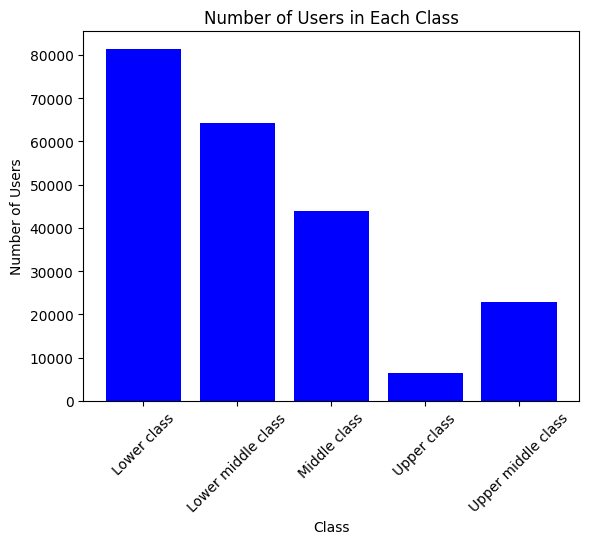

In [25]:
import matplotlib.pyplot as plt

# Group the DataFrame by Class and count the number of users in each class
class_counts = df_class.groupBy("Class").count().orderBy("Class").collect()

# Extract class names and corresponding user counts
classes = [row["Class"] for row in class_counts]
user_counts = [row["count"] for row in class_counts]

# Plot the bar graph
plt.bar(classes, user_counts, color='blue')
plt.xlabel('Class')
plt.ylabel('Number of Users')
plt.title('Number of Users in Each Class')
plt.xticks(rotation=45)  # Rotate x-axis labels for better readability
plt.show()


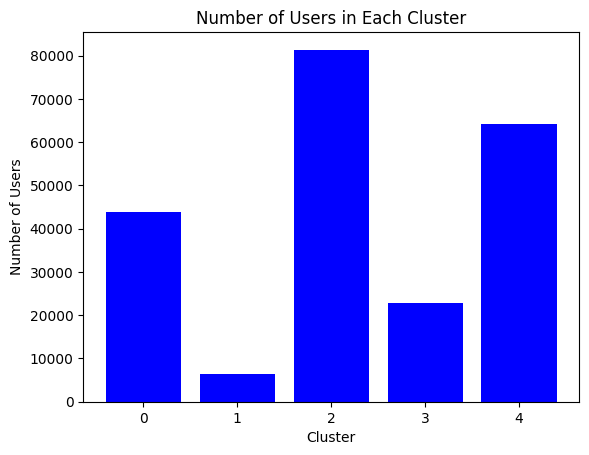

In [10]:
import matplotlib.pyplot as plt

# Group the predictions by cluster and count the number of users in each cluster
cluster_counts = predictions.groupBy("prediction").count().orderBy("prediction").collect()

# Extract cluster numbers and corresponding user counts
clusters = [row["prediction"] for row in cluster_counts]
user_counts = [row["count"] for row in cluster_counts]

# Plot the bar graph
plt.bar(clusters, user_counts, color='blue')
plt.xlabel('Cluster')
plt.ylabel('Number of Users')
plt.title('Number of Users in Each Cluster')
plt.xticks(clusters)
plt.show()


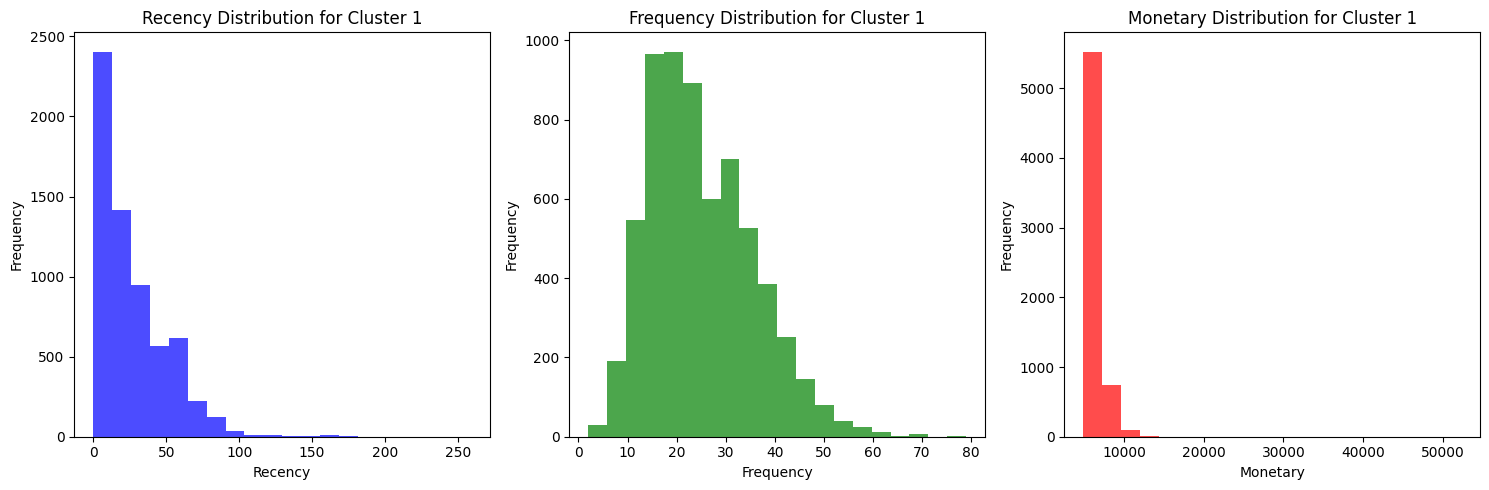

In [15]:
import matplotlib.pyplot as plt

# Filter the DataFrame to get RFM values of users in cluster 1
cluster_1_rfm = rfm_data.filter(rfm_data["prediction"] == 1)

# Extract RFM values for cluster 1
recency_values = cluster_1_rfm.select("recency").rdd.flatMap(lambda x: x).collect()
frequency_values = cluster_1_rfm.select("frequency").rdd.flatMap(lambda x: x).collect()
monetary_values = cluster_1_rfm.select("monetary").rdd.flatMap(lambda x: x).collect()

# Plot histograms for RFM values
plt.figure(figsize=(15, 5))

plt.subplot(1, 3, 1)
plt.hist(recency_values, bins=20, color='blue', alpha=0.7)
plt.xlabel('Recency')
plt.ylabel('Frequency')
plt.title('Recency Distribution for Cluster 1')

plt.subplot(1, 3, 2)
plt.hist(frequency_values, bins=20, color='green', alpha=0.7)
plt.xlabel('Frequency')
plt.ylabel('Frequency')
plt.title('Frequency Distribution for Cluster 1')

plt.subplot(1, 3, 3)
plt.hist(monetary_values, bins=20, color='red', alpha=0.7)
plt.xlabel('Monetary')
plt.ylabel('Frequency')
plt.title('Monetary Distribution for Cluster 1')

plt.tight_layout()
plt.show()


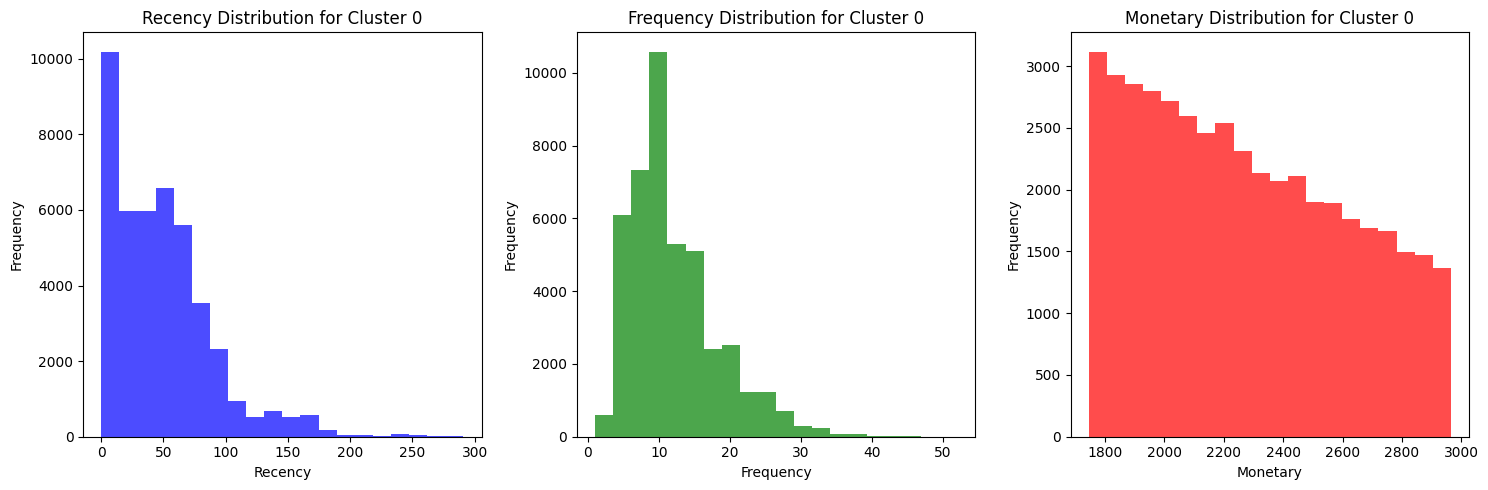

In [16]:
import matplotlib.pyplot as plt

# Filter the DataFrame to get RFM values of users in cluster 1
cluster_1_rfm = rfm_data.filter(rfm_data["prediction"] == 0)

# Extract RFM values for cluster 1
recency_values = cluster_1_rfm.select("recency").rdd.flatMap(lambda x: x).collect()
frequency_values = cluster_1_rfm.select("frequency").rdd.flatMap(lambda x: x).collect()
monetary_values = cluster_1_rfm.select("monetary").rdd.flatMap(lambda x: x).collect()

# Plot histograms for RFM values
plt.figure(figsize=(15, 5))

plt.subplot(1, 3, 1)
plt.hist(recency_values, bins=20, color='blue', alpha=0.7)
plt.xlabel('Recency')
plt.ylabel('Frequency')
plt.title('Recency Distribution for Cluster 0')

plt.subplot(1, 3, 2)
plt.hist(frequency_values, bins=20, color='green', alpha=0.7)
plt.xlabel('Frequency')
plt.ylabel('Frequency')
plt.title('Frequency Distribution for Cluster 0')

plt.subplot(1, 3, 3)
plt.hist(monetary_values, bins=20, color='red', alpha=0.7)
plt.xlabel('Monetary')
plt.ylabel('Frequency')
plt.title('Monetary Distribution for Cluster 0')

plt.tight_layout()
plt.show()


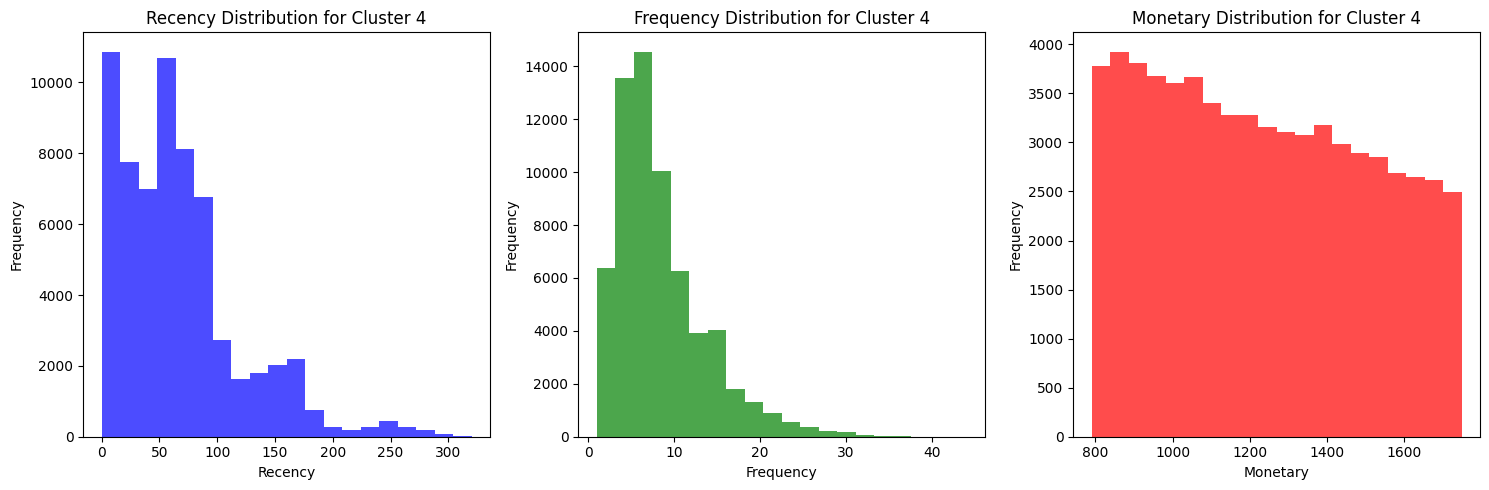

In [17]:
import matplotlib.pyplot as plt

# Filter the DataFrame to get RFM values of users in cluster 1
cluster_1_rfm = rfm_data.filter(rfm_data["prediction"] == 4)

# Extract RFM values for cluster 1
recency_values = cluster_1_rfm.select("recency").rdd.flatMap(lambda x: x).collect()
frequency_values = cluster_1_rfm.select("frequency").rdd.flatMap(lambda x: x).collect()
monetary_values = cluster_1_rfm.select("monetary").rdd.flatMap(lambda x: x).collect()

# Plot histograms for RFM values
plt.figure(figsize=(15, 5))

plt.subplot(1, 3, 1)
plt.hist(recency_values, bins=20, color='blue', alpha=0.7)
plt.xlabel('Recency')
plt.ylabel('Frequency')
plt.title('Recency Distribution for Cluster 4')

plt.subplot(1, 3, 2)
plt.hist(frequency_values, bins=20, color='green', alpha=0.7)
plt.xlabel('Frequency')
plt.ylabel('Frequency')
plt.title('Frequency Distribution for Cluster 4')

plt.subplot(1, 3, 3)
plt.hist(monetary_values, bins=20, color='red', alpha=0.7)
plt.xlabel('Monetary')
plt.ylabel('Frequency')
plt.title('Monetary Distribution for Cluster 4')

plt.tight_layout()
plt.show()


# Join rfm_data DataFrame with df DataFrame

In [10]:
df_with_rfm = df.join(rfm_data, "user_id", "left")
df_with_rfm.show()


+-------------------+-------------------+-------------------+-------------------+-------------------+----------+-------+-------------+-------------+-------------+-------------------+-------+---------+------------------+
|            user_id|         event_time|           order_id|         product_id|        category_id|     brand|  price|        cat_1|        cat_2|        cat_3|    last_order_time|recency|frequency|          monetary|
+-------------------+-------------------+-------------------+-------------------+-------------------+----------+-------+-------------+-------------+-------------+-------------------+-------+---------+------------------+
|1515915625441612480|2020-02-10 16:48:37|2348791608045994250|1515966223509122835|2268105430162997728|       neo|  20.81|  electronics|        audio|    headphone|2020-11-03 13:09:18|     18|       27|3760.3399999999997|
|1515915625443940057|2020-02-08 11:57:41|2348791388851666961|1515966223509335434|2309018577547559593|       ggg|  30.07|

In [8]:
df_with_rfm.count()

2060046

# Check null values

In [11]:
from pyspark.sql import functions as F
null_cnt = [F.sum(F.col(column).isNull().cast("integer")).alias(column) for column in df_with_rfm.columns]

null_cnt_df = df_with_rfm.agg(*null_cnt)

null_cnt_df.show()

+-------+----------+--------+----------+-----------+-----+-----+-----+-----+-----+---------------+-------+---------+--------+
|user_id|event_time|order_id|product_id|category_id|brand|price|cat_1|cat_2|cat_3|last_order_time|recency|frequency|monetary|
+-------+----------+--------+----------+-----------+-----+-----+-----+-----+-----+---------------+-------+---------+--------+
|      0|         0|       0|         0|          0|    0|    0|    0|    0|    0|              0|      0|        0|       0|
+-------+----------+--------+----------+-----------+-----+-----+-----+-----+-----+---------------+-------+---------+--------+



# Download Data

In [23]:
output_path = "RFMWithData"
df_with_rfm.coalesce(1).write.csv(output_path, header=True)


# Normalize the RFM scores to ensure that each feature contributes equally to the clustering process

In [12]:
# from pyspark.ml.feature import MinMaxScaler
# from pyspark.ml.linalg import Vectors
# from pyspark.sql import SparkSession

# # Initialize SparkSession
# spark = SparkSession.builder \
#     .appName("RFM_Normalization") \
#     .getOrCreate()

# # Convert the RFM scores to a dense vector
# rfm_vector = rfm_data.rdd.map(lambda x: (x["user_id"], Vectors.dense([x["recency"], x["frequency"], x["monetary"]]))).toDF(["user_id", "features"])

# # Initialize the MinMaxScaler
# scaler = MinMaxScaler(inputCol="features", outputCol="scaled_features")

# # Fit and transform the data
# scaler_model = scaler.fit(rfm_vector)
# normalized_rfm = scaler_model.transform(rfm_vector)

# # Show the normalized RFM data
# normalized_rfm.show()



In [13]:
# normalized_rfm.count()

In [14]:
# normalized_rfm.dtypes

In [15]:
from pyspark.sql.functions import udf
from pyspark.sql.types import IntegerType
from pyspark.ml.feature import MinMaxScaler
from pyspark.ml.linalg import Vectors
from pyspark.sql import SparkSession

# Initialize SparkSession
spark = SparkSession.builder \
    .appName("RFM_Normalization") \
    .getOrCreate()


# Convert the RFM scores to a dense vector
rfm_vector = rfm_data.rdd.map(lambda x: (x["user_id"], Vectors.dense([x["recency"], x["frequency"], x["monetary"]]))).toDF(["user_id", "features"])

# Initialize the MinMaxScaler
scaler = MinMaxScaler(inputCol="features", outputCol="scaled_features")

# Fit and transform the data
scaler_model = scaler.fit(rfm_vector)
normalized_rfm = scaler_model.transform(rfm_vector)

# Define a UDF to convert scaled features to integers
def to_int(value):
    factor = 100  # Adjust this factor as needed
    return int(value[0] * factor)  # Extracting the first element of the DenseVector

# Register the UDF
to_int_udf = udf(to_int, IntegerType())

# Apply the UDF to the scaled_features column
normalized_rfm = normalized_rfm.withColumn("scaled_features_int", to_int_udf("scaled_features"))

# Show the DataFrame
normalized_rfm.show()

# Stop SparkSession
# spark.stop()


24/02/19 11:56:05 WARN SparkSession: Using an existing Spark session; only runtime SQL configurations will take effect.


+-------------------+--------------------+--------------------+-------------------+
|            user_id|            features|     scaled_features|scaled_features_int|
+-------------------+--------------------+--------------------+-------------------+
|1515915625440051468| [42.0,19.0,1619.51]|[0.13084112149532...|                 13|
|1515915625440121544|   [48.0,7.0,878.32]|[0.14953271028037...|                 14|
|1515915625440937295|[2.0,18.0,1493.34...|[0.00623052959501...|                  0|
|1515915625440937382|[27.0,10.0,757.65...|[0.08411214953271...|                  8|
|1515915625440937580|   [42.0,8.0,275.05]|[0.13084112149532...|                 13|
|1515915625440940742|[66.0,2.0,59.9100...|[0.20560747663551...|                 20|
|1515915625440940932|[81.0,6.0,1854.25...|[0.25233644859813...|                 25|
|1515915625440941441|   [310.0,1.0,80.76]|[0.96573208722741...|                 96|
|1515915625440943934|[41.0,24.0,5877.4...|[0.12772585669781...|             

In [20]:
df_cleaned = normalized_rfm.drop( "scaled_features")

In [21]:
df_cleaned.show()

+-------------------+--------------------+-------------------+
|            user_id|            features|scaled_features_int|
+-------------------+--------------------+-------------------+
|1515915625440051468| [42.0,19.0,1619.51]|                 13|
|1515915625440121544|   [48.0,7.0,878.32]|                 14|
|1515915625440937295|[2.0,18.0,1493.34...|                  0|
|1515915625440937382|[27.0,10.0,757.65...|                  8|
|1515915625440937580|   [42.0,8.0,275.05]|                 13|
|1515915625440940742|[66.0,2.0,59.9100...|                 20|
|1515915625440940932|[81.0,6.0,1854.25...|                 25|
|1515915625440941441|   [310.0,1.0,80.76]|                 96|
|1515915625440943934|[41.0,24.0,5877.4...|                 12|
|1515915625440945265|[3.0,19.0,5456.57...|                  0|
|1515915625440946733| [33.0,26.0,2698.23]|                 10|
|1515915625440947224|[59.0,7.0,198.679...|                 18|
|1515915625440947741| [7.0,50.0,10036.37]|             

In [23]:
df_cleaned.dtypes

[('user_id', 'bigint'), ('features', 'vector'), ('scaled_features_int', 'int')]

In [30]:
# from pyspark.sql.functions import udf
# from pyspark.sql.types import ArrayType, DoubleType, IntegerType
# from pyspark.ml.feature import MinMaxScaler
# from pyspark.ml.linalg import Vectors
# from pyspark.sql import SparkSession

# spark = SparkSession.builder \
#     .appName("RFM_Normalization") \
#     .getOrCreate()

# # Convert the RFM scores to a dense vector
# rfm_vector = rfm_data.rdd.map(lambda x: (x["user_id"], Vectors.dense([x["recency"], x["frequency"], x["monetary"]]))).toDF(["user_id", "features"])

# # Initialize the MinMaxScaler
# scaler = MinMaxScaler(inputCol="features", outputCol="scaled_features")

# # Fit and transform the data
# scaler_model = scaler.fit(rfm_vector)
# normalized_rfm = scaler_model.transform(rfm_vector)

# # Define a UDF to convert the DenseVector to a list of doubles
# def vector_to_list(vector):
#     return [float(value) for value in vector.toArray()]

# # Register the UDF
# vector_to_list_udf = udf(vector_to_list, ArrayType(DoubleType()))

# # Apply the UDF to the scaled_features column
# normalized_rfm = normalized_rfm.withColumn("features_list", vector_to_list_udf("features"))

# # normalized_rfm.show()

# # Stop SparkSession
# # spark.stop()


# # Define a UDF to convert scaled features to integers
# def to_int(value):
#     factor = 100  # Adjust this factor as needed
#     return int(value[0] * factor)  # Extracting the first element of the DenseVector

# # Register the UDF
# to_int_udf = udf(to_int, IntegerType())

# # Apply the UDF to the scaled_features column
# normalized_rfm = normalized_rfm.withColumn("scaled_features_int", to_int_udf("scaled_features"))

# # Show the DataFrame
# normalized_rfm.show()

# # Stop SparkSession
# # spark.stop()



+-------------------+--------------------+--------------------+--------------------+-------------------+
|            user_id|            features|     scaled_features|       features_list|scaled_features_int|
+-------------------+--------------------+--------------------+--------------------+-------------------+
|1515915625440051468| [42.0,19.0,1619.51]|[0.13084112149532...|[42.0, 19.0, 1619...|                 13|
|1515915625440121544|   [48.0,7.0,878.32]|[0.14953271028037...| [48.0, 7.0, 878.32]|                 14|
|1515915625440937295|[2.0,18.0,1493.34...|[0.00623052959501...|[2.0, 18.0, 1493....|                  0|
|1515915625440937382|[27.0,10.0,757.65...|[0.08411214953271...|[27.0, 10.0, 757....|                  8|
|1515915625440937580|   [42.0,8.0,275.05]|[0.13084112149532...| [42.0, 8.0, 275.05]|                 13|
|1515915625440940742|[66.0,2.0,59.9100...|[0.20560747663551...|[66.0, 2.0, 59.91...|                 20|
|1515915625440940932|[81.0,6.0,1854.25...|[0.2523364485

In [31]:
normalized_rfm.dtypes

[('user_id', 'bigint'),
 ('features', 'vector'),
 ('scaled_features', 'vector'),
 ('features_list', 'array<double>'),
 ('scaled_features_int', 'int')]

In [32]:
df_cleaned = normalized_rfm.drop( "scaled_features", "features")

In [33]:
df_cleaned.show()

+-------------------+--------------------+-------------------+
|            user_id|       features_list|scaled_features_int|
+-------------------+--------------------+-------------------+
|1515915625440051468|[42.0, 19.0, 1619...|                 13|
|1515915625440121544| [48.0, 7.0, 878.32]|                 14|
|1515915625440937295|[2.0, 18.0, 1493....|                  0|
|1515915625440937382|[27.0, 10.0, 757....|                  8|
|1515915625440937580| [42.0, 8.0, 275.05]|                 13|
|1515915625440940742|[66.0, 2.0, 59.91...|                 20|
|1515915625440940932|[81.0, 6.0, 1854....|                 25|
|1515915625440941441| [310.0, 1.0, 80.76]|                 96|
|1515915625440943934|[41.0, 24.0, 5877...|                 12|
|1515915625440945265|[3.0, 19.0, 5456....|                  0|
|1515915625440946733|[33.0, 26.0, 2698...|                 10|
|1515915625440947224|[59.0, 7.0, 198.6...|                 18|
|1515915625440947741|[7.0, 50.0, 10036...|             

In [35]:
df_cleaned = df_cleaned.withColumnRenamed("features_list", "features")

In [36]:
df_cleaned = df_cleaned.withColumnRenamed("scaled_features_int", "scaled_features")

In [37]:
df_cleaned.show()

+-------------------+--------------------+---------------+
|            user_id|            features|scaled_features|
+-------------------+--------------------+---------------+
|1515915625440051468|[42.0, 19.0, 1619...|             13|
|1515915625440121544| [48.0, 7.0, 878.32]|             14|
|1515915625440937295|[2.0, 18.0, 1493....|              0|
|1515915625440937382|[27.0, 10.0, 757....|              8|
|1515915625440937580| [42.0, 8.0, 275.05]|             13|
|1515915625440940742|[66.0, 2.0, 59.91...|             20|
|1515915625440940932|[81.0, 6.0, 1854....|             25|
|1515915625440941441| [310.0, 1.0, 80.76]|             96|
|1515915625440943934|[41.0, 24.0, 5877...|             12|
|1515915625440945265|[3.0, 19.0, 5456....|              0|
|1515915625440946733|[33.0, 26.0, 2698...|             10|
|1515915625440947224|[59.0, 7.0, 198.6...|             18|
|1515915625440947741|[7.0, 50.0, 10036...|              2|
|1515915625440949051|[14.0, 30.0, 2144...|              

In [39]:
df_cleaned.dtypes

[('user_id', 'bigint'),
 ('features', 'array<double>'),
 ('scaled_features', 'int')]

In [40]:
from pyspark.sql.functions import udf
from pyspark.sql.types import ArrayType, DoubleType, IntegerType
from pyspark.ml.feature import MinMaxScaler
from pyspark.ml.linalg import Vectors
from pyspark.sql import SparkSession

# Initialize SparkSession
spark = SparkSession.builder \
    .appName("RFM_Normalization") \
    .getOrCreate()

# Convert the RFM scores to a dense vector
rfm_vector = rfm_data.rdd.map(lambda x: (x["user_id"], Vectors.dense([x["recency"], x["frequency"], x["monetary"]]))).toDF(["user_id", "features"])

# Initialize the MinMaxScaler
scaler = MinMaxScaler(inputCol="features", outputCol="scaled_features")

# Fit and transform the data
scaler_model = scaler.fit(rfm_vector)
normalized_rfm = scaler_model.transform(rfm_vector)

# Define a UDF to convert the DenseVector to an array of doubles
def vector_to_array(vector):
    return vector.toArray().tolist()

# Register the UDF
vector_to_array_udf = udf(vector_to_array, ArrayType(DoubleType()))

# Apply the UDF to the features column
normalized_rfm = normalized_rfm.withColumn("features", vector_to_array_udf("features"))

# Show the DataFrame
normalized_rfm.show()

# Stop SparkSession
# spark.stop()


24/02/19 12:29:04 WARN SparkSession: Using an existing Spark session; only runtime SQL configurations will take effect.


+-------------------+--------------------+--------------------+
|            user_id|            features|     scaled_features|
+-------------------+--------------------+--------------------+
|1515915625440051468|[42.0, 19.0, 1619...|[0.13084112149532...|
|1515915625440121544| [48.0, 7.0, 878.32]|[0.14953271028037...|
|1515915625440937295|[2.0, 18.0, 1493....|[0.00623052959501...|
|1515915625440937382|[27.0, 10.0, 757....|[0.08411214953271...|
|1515915625440937580| [42.0, 8.0, 275.05]|[0.13084112149532...|
|1515915625440940742|[66.0, 2.0, 59.91...|[0.20560747663551...|
|1515915625440940932|[81.0, 6.0, 1854....|[0.25233644859813...|
|1515915625440941441| [310.0, 1.0, 80.76]|[0.96573208722741...|
|1515915625440943934|[41.0, 24.0, 5877...|[0.12772585669781...|
|1515915625440945265|[3.0, 19.0, 5456....|[0.00934579439252...|
|1515915625440946733|[33.0, 26.0, 2698...|[0.10280373831775...|
|1515915625440947224|[59.0, 7.0, 198.6...|[0.18380062305295...|
|1515915625440947741|[7.0, 50.0, 10036..

In [41]:
df_cleaned=normalized_rfm

In [42]:
from pyspark.ml.clustering import KMeans
from pyspark.sql import SparkSession

# Initialize SparkSession
spark = SparkSession.builder \
    .appName("RFM_Clustering") \
    .getOrCreate()

# Sample data - replace this with your actual DataFrame
# normalized_rfm = spark.createDataFrame([...], ["user_id", "scaled_features"])

# Initialize KMeans with the number of clusters
kmeans = KMeans(k=5, seed=42)

# Fit the KMeans model to the data
model = kmeans.fit(df_cleaned)

# Make predictions
predictions = model.transform(df_cleaned)

# Show the cluster assignment for each user
predictions.select("user_id", "prediction").show()

# Stop SparkSession
# spark.stop()


24/02/19 12:29:34 WARN SparkSession: Using an existing Spark session; only runtime SQL configurations will take effect.
24/02/19 12:29:34 ERROR Instrumentation: java.lang.IllegalArgumentException: requirement failed: Column features must be of type equal to one of the following types: [struct<type:tinyint,size:int,indices:array<int>,values:array<double>>, array<double>, array<float>] but was actually of type array<double>.
	at scala.Predef$.require(Predef.scala:281)
	at org.apache.spark.ml.util.SchemaUtils$.checkColumnTypes(SchemaUtils.scala:63)
	at org.apache.spark.ml.util.SchemaUtils$.validateVectorCompatibleColumn(SchemaUtils.scala:205)
	at org.apache.spark.ml.clustering.KMeansParams.validateAndTransformSchema(KMeans.scala:121)
	at org.apache.spark.ml.clustering.KMeansParams.validateAndTransformSchema$(KMeans.scala:120)
	at org.apache.spark.ml.clustering.KMeans.validateAndTransformSchema(KMeans.scala:295)
	at org.apache.spark.ml.clustering.KMeans.transformSchema(KMeans.scala:599)
	a

IllegalArgumentException: requirement failed: Column features must be of type equal to one of the following types: [struct<type:tinyint,size:int,indices:array<int>,values:array<double>>, array<double>, array<float>] but was actually of type array<double>.

In [32]:
# from pyspark.sql.functions import min as min_, max as max_, mean as mean_

# # Calculate minimum, maximum, and mean for each column
# recency_stats = rfm_data.agg(min_("recency").alias("min_recency"), 
#                               max_("recency").alias("max_recency"), 
#                               mean_("recency").alias("mean_recency")).head()

# frequency_stats = rfm_data.agg(min_("frequency").alias("min_frequency"), 
#                                 max_("frequency").alias("max_frequency"), 
#                                 mean_("frequency").alias("mean_frequency")).head()

# monetary_stats = rfm_data.agg(min_("monetary").alias("min_monetary"), 
#                                max_("monetary").alias("max_monetary"), 
#                                mean_("monetary").alias("mean_monetary")).head()

# # Print the statistics for each column
# print("Recency Stats:")
# print("Min Recency:", recency_stats.min_recency)
# print("Max Recency:", recency_stats.max_recency)
# print("Mean Recency:", recency_stats.mean_recency)
# print()

# print("Frequency Stats:")
# print("Min Frequency:", frequency_stats.min_frequency)
# print("Max Frequency:", frequency_stats.max_frequency)
# print("Mean Frequency:", frequency_stats.mean_frequency)
# print()

# print("Monetary Stats:")
# print("Min Monetary:", monetary_stats.min_monetary)
# print("Max Monetary:", monetary_stats.max_monetary)
# print("Mean Monetary:", monetary_stats.mean_monetary)


Recency Stats:
Min Recency: 0
Max Recency: 321
Mean Recency: 69.49061430323442

Frequency Stats:
Min Frequency: 1
Max Frequency: 79
Mean Frequency: 9.427001153191412

Monetary Stats:
Min Monetary: 0.02
Max Monetary: 52328.31
Mean Monetary: 1510.4277025711258


In [ ]:
    # Very recent: 0 to 37.39
    # Recent: 37.39 to 69.49
    # Average: 69.49 to 101.59 (mean recency falls in this range)
    # Less recent: 101.59 to 288.9
    # Least recent: 288.9 to 321

    # Very low frequency: 1 to 4.71
    # Low frequency: 4.71 to 9.427
    # Average frequency: 9.427 to 14.14 (mean frequency falls in this range)
    # High frequency: 14.14 to 39.5
    # Very high frequency: 39.5 to 79

    # Very low monetary: 0.02 to 755.215
    # Low monetary: 755.215 to 1510.43
    # Average monetary: 1510.43 to 2265.645 (mean monetary falls in this range)
    # High monetary: 2265.645 to 26164.155
    # Very high monetary: 26164.155 to 52328.31

In [34]:
# from pyspark.sql.functions import when

# # Define the ranges and class values for each class
# class_ranges = {
#     "Poor": {
#         "recency": (0, 37),
#         "frequency": (1, 4),
#         "monetary": (0.02, 755)
#     },
#     "Lower Middle": {
#         "recency": (37, 65),
#         "frequency": (4, 8),
#         "monetary": (755, 1500)
#     },
#     "Middle": {
#         "recency": (65, 102),
#         "frequency": (8, 15),
#         "monetary": (1500, 2270)
#     },
#     "Upper Middle": {
#         "recency": (102, 288),
#         "frequency": (15, 41),
#         "monetary": (2270, 26165)
#     },
#     "Rich": {
#         "recency": (288, 322),
#         "frequency": (41, 80),
#         "monetary": (26165, 52330)
#     }
# }

# # Iterate over each class and assign class values based on RFM scores
# for class_name, ranges in class_ranges.items():
#     recency_range = ranges["recency"]
#     frequency_range = ranges["frequency"]
#     monetary_range = ranges["monetary"]
    
#     # Assign class value based on RFM scores
#     df_class = rfm_data.withColumn(class_name, 
#                                    when((col("recency").between(recency_range[0], recency_range[1])) & 
#                                         (col("frequency").between(frequency_range[0], frequency_range[1])) & 
#                                         (col("monetary").between(monetary_range[0], monetary_range[1])), class_name)
#                                    .otherwise("Other"))

# # Show the DataFrame with the assigned class values
# df_class.show()


In [27]:
# Join rfm_data DataFrame with df DataFrame
df_with_norm = df_with_rfm.join(df_norm, "user_id", "left")

df_with_norm.show()


+-------------------+-------------------+-------------------+-------------------+-------------------+----------+-------+-------------+-------------+-------------+-------------------+-------+---------+------------------+--------------------+
|            user_id|         event_time|           order_id|         product_id|        category_id|     brand|  price|        cat_1|        cat_2|        cat_3|    last_order_time|recency|frequency|          monetary|     scaled_features|
+-------------------+-------------------+-------------------+-------------------+-------------------+----------+-------+-------------+-------------+-------------+-------------------+-------+---------+------------------+--------------------+
|1515915625441612480|2020-02-10 16:48:37|2348791608045994250|1515966223509122835|2268105430162997728|       neo|  20.81|  electronics|        audio|    headphone|2020-11-03 13:09:18|     18|       27|3760.3399999999997|[0.05607476635514...|
|1515915625443940057|2020-02-08 11:5

In [30]:
# output_path = "NormWithData"
# df_with_norm.coalesce(1).write.csv(output_path, header=True)


In [37]:
df_with_norm.dtypes

[('user_id', 'bigint'),
 ('event_time', 'timestamp'),
 ('order_id', 'bigint'),
 ('product_id', 'bigint'),
 ('category_id', 'bigint'),
 ('brand', 'string'),
 ('price', 'double'),
 ('cat_1', 'string'),
 ('cat_2', 'string'),
 ('cat_3', 'string'),
 ('last_order_time', 'timestamp'),
 ('recency', 'int'),
 ('frequency', 'bigint'),
 ('monetary', 'double'),
 ('scaled_features', 'vector')]

In [39]:
from pyspark.sql.functions import udf
from pyspark.sql.types import IntegerType
from pyspark.ml.linalg import Vectors, VectorUDT

# Define a UDF to convert each element of the vector to an integer
def vector_to_int(vector):
    return Vectors.dense([int(val) for val in vector])

# Register the UDF
vector_to_int_udf = udf(vector_to_int, VectorUDT())

# Apply the UDF to the scaled_features column
df_vect = df_with_norm.withColumn("scaled_features_int", vector_to_int_udf("scaled_features"))

# Show the DataFrame
df_vect.show()


+-------------------+-------------------+-------------------+-------------------+-------------------+----------+-------+-------------+-------------+-------------+-------------------+-------+---------+------------------+--------------------+-------------------+
|            user_id|         event_time|           order_id|         product_id|        category_id|     brand|  price|        cat_1|        cat_2|        cat_3|    last_order_time|recency|frequency|          monetary|     scaled_features|scaled_features_int|
+-------------------+-------------------+-------------------+-------------------+-------------------+----------+-------+-------------+-------------+-------------+-------------------+-------+---------+------------------+--------------------+-------------------+
|1515915625441612480|2020-02-10 16:48:37|2348791608045994250|1515966223509122835|2268105430162997728|       neo|  20.81|  electronics|        audio|    headphone|2020-11-03 13:09:18|     18|       27|3760.339999999999

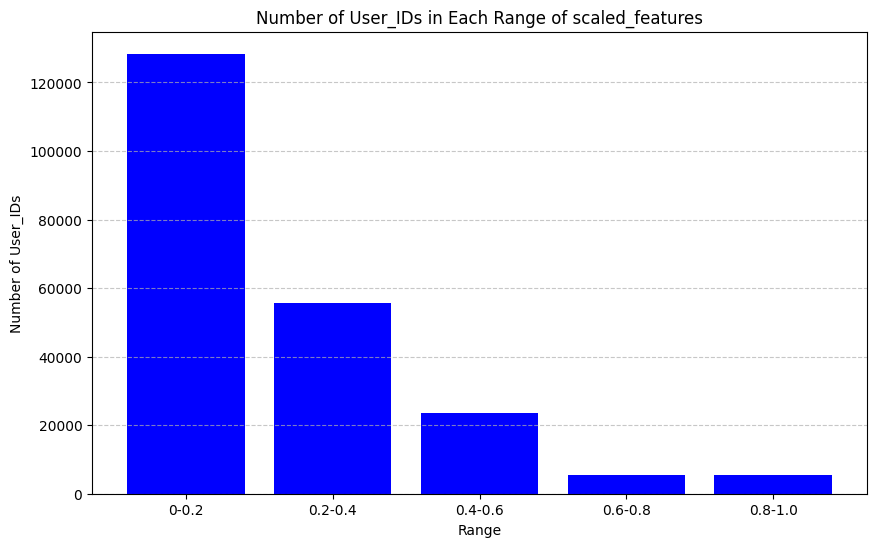

In [43]:
import matplotlib.pyplot as plt
from pyspark.ml.feature import Bucketizer
from pyspark.sql.functions import col

# Define the range boundaries for bucketizing
boundaries = [0, 20, 40, 60, 80, 100]

# Bucketize the scaled_features column
bucketizer = Bucketizer(splits=boundaries, inputCol="scaled_features_int", outputCol="range")
df_bucketized = bucketizer.transform(normalized_rfm1)

# Group the data by range and count the number of user_id in each range
range_counts = df_bucketized.groupBy("range").count().orderBy("range").toPandas()

# Plot the graph
plt.figure(figsize=(10, 6))
plt.bar(range_counts["range"], range_counts["count"], color='blue')
plt.xlabel('Range')
plt.ylabel('Number of User_IDs')
plt.title('Number of User_IDs in Each Range of scaled_features')
plt.xticks(range(5), ['0-0.2', '0.2-0.4', '0.4-0.6', '0.6-0.8', '0.8-1.0'])
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()


In [21]:
from pyspark.ml.clustering import KMeans
from pyspark.sql import SparkSession

# Initialize SparkSession
spark = SparkSession.builder \
    .appName("RFM_Clustering") \
    .getOrCreate()

# Sample data - replace this with your actual DataFrame
# normalized_rfm = spark.createDataFrame([...], ["user_id", "scaled_features"])

# Initialize KMeans with the number of clusters
kmeans = KMeans(k=5, seed=42)

# Fit the KMeans model to the data
model = kmeans.fit(normalized_rfm)

# Make predictions
# predictions = model.transform(normalized_rfm)

# Show the cluster assignment for each user
# predictions.select("user_id", "prediction").show()

# Stop SparkSession
# spark.stop()


24/02/19 08:46:05 ERROR PythonRunner: Python worker exited unexpectedly (crashed)
org.apache.spark.api.python.PythonException: Traceback (most recent call last):
  File "/home/hadoop/spark-3.5.0-bin-hadoop3/python/lib/pyspark.zip/pyspark/worker.py", line 1225, in main
    eval_type = read_int(infile)
  File "/home/hadoop/spark-3.5.0-bin-hadoop3/python/lib/pyspark.zip/pyspark/serializers.py", line 596, in read_int
    raise EOFError
EOFError

	at org.apache.spark.api.python.BasePythonRunner$ReaderIterator.handlePythonException(PythonRunner.scala:572)
	at org.apache.spark.api.python.PythonRunner$$anon$3.read(PythonRunner.scala:784)
	at org.apache.spark.api.python.PythonRunner$$anon$3.read(PythonRunner.scala:766)
	at org.apache.spark.api.python.BasePythonRunner$ReaderIterator.hasNext(PythonRunner.scala:525)
	at org.apache.spark.InterruptibleIterator.hasNext(InterruptibleIterator.scala:37)
	at scala.collection.Iterator$$anon$11.hasNext(Iterator.scala:491)
	at scala.collection.Iterator$$ano

Py4JJavaError: An error occurred while calling o459.fit.
: org.apache.spark.SparkException: Job aborted due to stage failure: Task 5 in stage 171.0 failed 1 times, most recent failure: Lost task 5.0 in stage 171.0 (TID 287) (192.168.1.157 executor driver): java.lang.NullPointerException

Driver stacktrace:
	at org.apache.spark.scheduler.DAGScheduler.failJobAndIndependentStages(DAGScheduler.scala:2844)
	at org.apache.spark.scheduler.DAGScheduler.$anonfun$abortStage$2(DAGScheduler.scala:2780)
	at org.apache.spark.scheduler.DAGScheduler.$anonfun$abortStage$2$adapted(DAGScheduler.scala:2779)
	at scala.collection.mutable.ResizableArray.foreach(ResizableArray.scala:62)
	at scala.collection.mutable.ResizableArray.foreach$(ResizableArray.scala:55)
	at scala.collection.mutable.ArrayBuffer.foreach(ArrayBuffer.scala:49)
	at org.apache.spark.scheduler.DAGScheduler.abortStage(DAGScheduler.scala:2779)
	at org.apache.spark.scheduler.DAGScheduler.$anonfun$handleTaskSetFailed$1(DAGScheduler.scala:1242)
	at org.apache.spark.scheduler.DAGScheduler.$anonfun$handleTaskSetFailed$1$adapted(DAGScheduler.scala:1242)
	at scala.Option.foreach(Option.scala:407)
	at org.apache.spark.scheduler.DAGScheduler.handleTaskSetFailed(DAGScheduler.scala:1242)
	at org.apache.spark.scheduler.DAGSchedulerEventProcessLoop.doOnReceive(DAGScheduler.scala:3048)
	at org.apache.spark.scheduler.DAGSchedulerEventProcessLoop.onReceive(DAGScheduler.scala:2982)
	at org.apache.spark.scheduler.DAGSchedulerEventProcessLoop.onReceive(DAGScheduler.scala:2971)
	at org.apache.spark.util.EventLoop$$anon$1.run(EventLoop.scala:49)
	at org.apache.spark.scheduler.DAGScheduler.runJob(DAGScheduler.scala:984)
	at org.apache.spark.SparkContext.runJob(SparkContext.scala:2398)
	at org.apache.spark.SparkContext.runJob(SparkContext.scala:2419)
	at org.apache.spark.SparkContext.runJob(SparkContext.scala:2438)
	at org.apache.spark.SparkContext.runJob(SparkContext.scala:2463)
	at org.apache.spark.rdd.RDD.count(RDD.scala:1293)
	at org.apache.spark.rdd.RDD.$anonfun$takeSample$1(RDD.scala:626)
	at org.apache.spark.rdd.RDDOperationScope$.withScope(RDDOperationScope.scala:151)
	at org.apache.spark.rdd.RDDOperationScope$.withScope(RDDOperationScope.scala:112)
	at org.apache.spark.rdd.RDD.withScope(RDD.scala:407)
	at org.apache.spark.rdd.RDD.takeSample(RDD.scala:615)
	at org.apache.spark.mllib.clustering.KMeans.initKMeansParallel(KMeans.scala:400)
	at org.apache.spark.mllib.clustering.KMeans.runAlgorithmWithWeight(KMeans.scala:273)
	at org.apache.spark.mllib.clustering.KMeans.runWithWeight(KMeans.scala:231)
	at org.apache.spark.ml.clustering.KMeans.trainWithRow(KMeans.scala:446)
	at org.apache.spark.ml.clustering.KMeans.$anonfun$fit$1(KMeans.scala:382)
	at org.apache.spark.ml.util.Instrumentation$.$anonfun$instrumented$1(Instrumentation.scala:191)
	at scala.util.Try$.apply(Try.scala:213)
	at org.apache.spark.ml.util.Instrumentation$.instrumented(Instrumentation.scala:191)
	at org.apache.spark.ml.clustering.KMeans.fit(KMeans.scala:371)
	at org.apache.spark.ml.clustering.KMeans.fit(KMeans.scala:295)
	at sun.reflect.NativeMethodAccessorImpl.invoke0(Native Method)
	at sun.reflect.NativeMethodAccessorImpl.invoke(NativeMethodAccessorImpl.java:62)
	at sun.reflect.DelegatingMethodAccessorImpl.invoke(DelegatingMethodAccessorImpl.java:43)
	at java.lang.reflect.Method.invoke(Method.java:498)
	at py4j.reflection.MethodInvoker.invoke(MethodInvoker.java:244)
	at py4j.reflection.ReflectionEngine.invoke(ReflectionEngine.java:374)
	at py4j.Gateway.invoke(Gateway.java:282)
	at py4j.commands.AbstractCommand.invokeMethod(AbstractCommand.java:132)
	at py4j.commands.CallCommand.execute(CallCommand.java:79)
	at py4j.ClientServerConnection.waitForCommands(ClientServerConnection.java:182)
	at py4j.ClientServerConnection.run(ClientServerConnection.java:106)
	at java.lang.Thread.run(Thread.java:750)
Caused by: java.lang.NullPointerException


24/02/19 08:46:06 WARN BlockManager: Putting block rdd_255_1 failed due to exception org.apache.spark.TaskKilledException.
24/02/19 08:46:06 WARN BlockManager: Block rdd_255_1 could not be removed as it was not found on disk or in memory
24/02/19 08:46:06 WARN TaskSetManager: Lost task 1.0 in stage 171.0 (TID 283) (192.168.1.157 executor driver): TaskKilled (Stage cancelled: Job aborted due to stage failure: Task 5 in stage 171.0 failed 1 times, most recent failure: Lost task 5.0 in stage 171.0 (TID 287) (192.168.1.157 executor driver): java.lang.NullPointerException

Driver stacktrace:)
24/02/19 08:46:06 WARN BlockManager: Putting block rdd_255_4 failed due to exception org.apache.spark.TaskKilledException.
24/02/19 08:46:06 WARN BlockManager: Block rdd_255_4 could not be removed as it was not found on disk or in memory
24/02/19 08:46:06 WARN TaskSetManager: Lost task 4.0 in stage 171.0 (TID 286) (192.168.1.157 executor driver): TaskKilled (Stage cancelled: Job aborted due to stage fa

/tmp/ipykernel_42775/2455338906.py:2: DeprecationWarning: 
Pyarrow will become a required dependency of pandas in the next major release of pandas (pandas 3.0),
(to allow more performant data types, such as the Arrow string type, and better interoperability with other libraries)
but was not found to be installed on your system.
If this would cause problems for you,
please provide us feedback at https://github.com/pandas-dev/pandas/issues/54466
        
  import pandas as pd


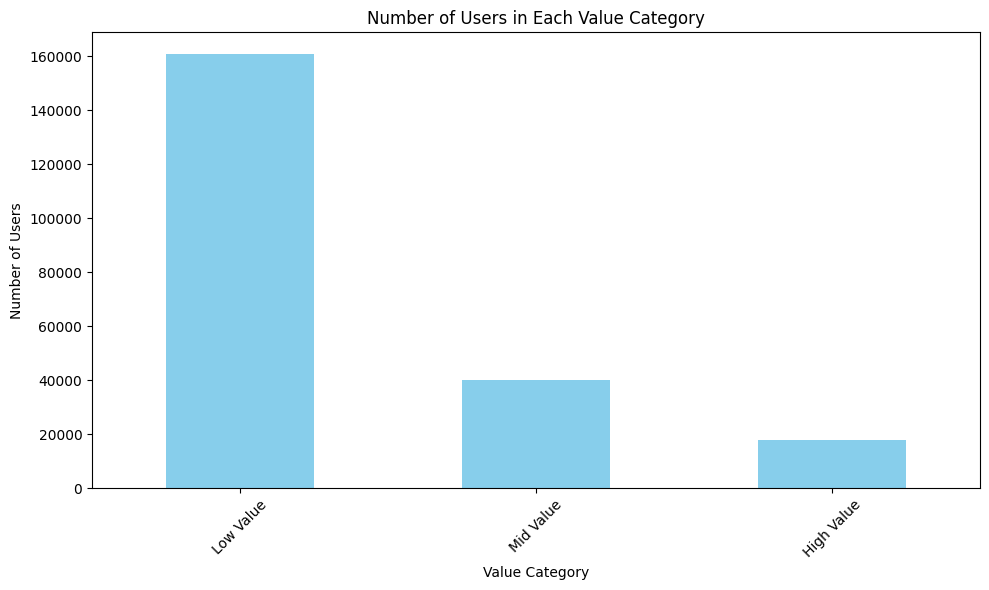

In [6]:
import matplotlib.pyplot as plt
import pandas as pd

# Convert the PySpark DataFrame to a Pandas DataFrame
rfm_scores_pd = rfm_scores.toPandas()

# Count the number of users in each segment
segment_counts = rfm_scores_pd["segment"].value_counts()

# Plot the graph
plt.figure(figsize=(10, 6))
segment_counts.plot(kind="bar", color="skyblue")
plt.title("Number of Users in Each Value Category")
plt.xlabel("Value Category")
plt.ylabel("Number of Users")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


In [10]:
from pyspark.sql import SparkSession
from pyspark.sql.functions import col, month


# Extract month component from event_time column
df_mon = df.withColumn("month_key", month(col("event_time")))

# Show the DataFrame with new column month_key
df_mon.select("event_time", "month_key").show()



+-------------------+---------+
|         event_time|month_key|
+-------------------+---------+
|2020-04-29 20:11:49|        4|
|2020-04-29 23:42:11|        4|
|2020-04-30 18:01:51|        4|
|2020-04-30 19:27:36|        4|
|2020-04-30 21:37:48|        4|
|2020-05-01 12:54:33|        5|
|2020-05-01 22:40:42|        5|
|2020-05-02 23:25:58|        5|
|2020-05-04 07:07:11|        5|
|2020-05-06 08:37:23|        5|
|2020-05-06 11:40:59|        5|
|2020-05-06 18:58:35|        5|
|2020-05-07 17:06:03|        5|
|2020-05-07 17:42:39|        5|
|2020-05-08 00:34:21|        5|
|2020-05-09 06:14:01|        5|
|2020-05-10 14:59:23|        5|
|2020-05-10 19:13:40|        5|
|2020-05-11 08:18:33|        5|
|2020-05-11 10:41:08|        5|
+-------------------+---------+
only showing top 20 rows



In [11]:
df_mon.show()

+-------------------+-------------------+-------------------+-------------------+-------+------+-------------------+-----------+-----------+---------------+---------+
|         event_time|           order_id|         product_id|        category_id|  brand| price|            user_id|      cat_1|      cat_2|          cat_3|month_key|
+-------------------+-------------------+-------------------+-------------------+-------+------+-------------------+-----------+-----------+---------------+---------+
|2020-04-29 20:11:49|2298069964415828136|1515966223509122874|2268105407933187062|     hp|152.52|1515915625443027224|  computers|peripherals|        printer|        4|
|2020-04-29 23:42:11|2298175846491357353|1515966223509122666|2268105430162997728|samsung|  8.08|1515915625445938216|electronics|      audio|      headphone|        4|
|2020-04-30 18:01:51|2298729326712980173|1515966223509089265|2360741866917331945|   beko|231.46|1515915625446617606| appliances|environment|air_conditioner|        4

# Calculate Purchase(sum of price) by users per year-month

In [19]:
from pyspark.sql.functions import col, sum, to_date

user_purchase_month = df_mon.withColumn("purchase_month", to_date(col("event_time")).substr(1, 7)).groupBy("month_key").agg(sum("price").alias("Monthly purchase by user")).orderBy("month_key")

user_purchase_month.show()




+---------+------------------------+
|month_key|Monthly purchase by user|
+---------+------------------------+
|        1|       1726269.314012686|
|        2|        2212593.63003171|
|        3|      2836594.8920063437|
|        4|      1659148.3920063446|
|        5|       7638151.942006315|
|        6|       7479405.318025369|
|        7|    1.6006443429999901E7|
|        8|     2.730199569200609E7|
|        9|    1.6757457076018898E7|
|       10|     1.936188824805694E7|
|       11|    1.1767545436018975E7|
+---------+------------------------+



In [14]:
pip install matplotlib

Defaulting to user installation because normal site-packages is not writeable
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 11.6/11.6 MB 2.0 MB/s eta 0:00:00m eta 0:00:010:00:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 310.7/310.7 KB 2.4 MB/s eta 0:00:00m eta 0:00:010:01:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 18.2/18.2 MB 2.6 MB/s eta 0:00:00m eta 0:00:010:00:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.6/4.6 MB 1.2 MB/s eta 0:00:00m eta 0:00:010:00:010m
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 1.1 MB/s eta 0:00:00m eta 0:00:010:01:01
Note: you may need to restart the kernel to use updated packages.


In [16]:
pip install pandas

Defaulting to user installation because normal site-packages is not writeable
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.0/13.0 MB 2.2 MB/s eta 0:00:00m eta 0:00:010:00:01m
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 345.4/345.4 KB 1.9 MB/s eta 0:00:000:00:01m eta 0:00:01
Note: you may need to restart the kernel to use updated packages.


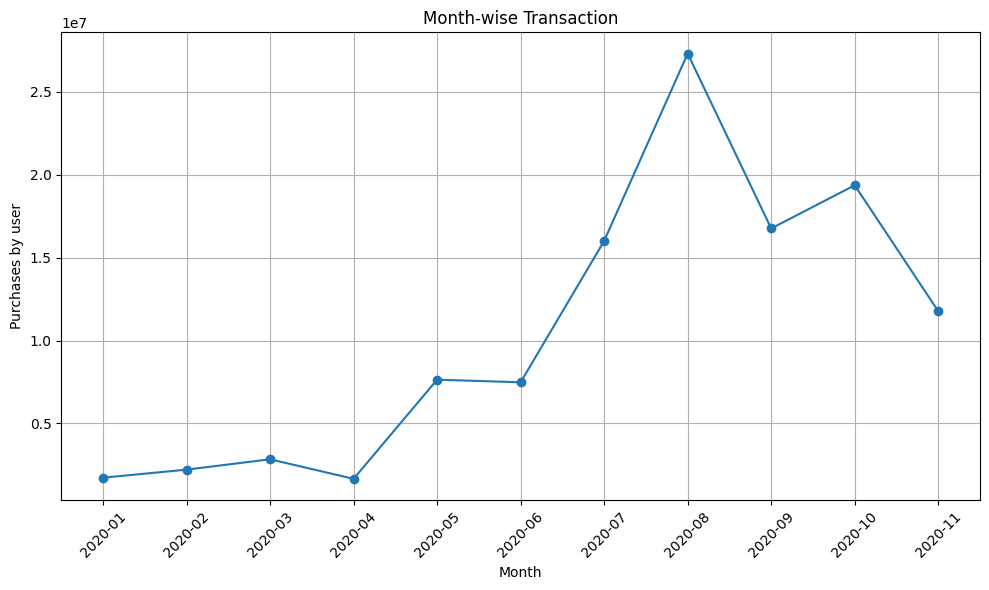

None

In [18]:
from pyspark.sql.functions import col, sum, to_date
import matplotlib.pyplot as plt

# Calculate GMV (sum of price) per year-month
user_purchase_month_GMV = df_mon.withColumn("purchase_month", to_date(col("event_time")).substr(1, 7)) \
    .groupBy("purchase_month") \
    .agg(sum("price").alias("Purchase by user")) \
    .orderBy("purchase_month")

# Convert PySpark DataFrame to Pandas DataFrame for plotting
user_purchase_month_GMV_pd = user_purchase_month_GMV.toPandas()

plt.figure(figsize=(10, 6))
plt.plot(user_purchase_month_GMV_pd["purchase_month"], user_purchase_month_GMV_pd["GMV"], marker='o', linestyle='-')
plt.title("Month-wise Transaction")
plt.xlabel("Month")
plt.ylabel("Purchases by user")
plt.xticks(rotation=45)
plt.grid(True)
plt.tight_layout()

display(plt.show())
